<a href="https://colab.research.google.com/github/Akstrov/MNIST_Simple_NN/blob/main/MNIST_Simple_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install fastai

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import torch
from fastai.vision.all import *

# Preparing the data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [6]:
def load_data_x(digit, type):
  digit_path = (path/type/str(digit)).ls().sorted()
  digit_tensors = [tensor(Image.open(o)) for o in digit_path]
  return torch.stack(digit_tensors).float()/255

In [7]:
(path/'training').ls()

(#10) [Path('training/9'),Path('training/7'),Path('training/3'),Path('training/0'),Path('training/5'),Path('training/4'),Path('training/6'),Path('training/8'),Path('training/2'),Path('training/1')]

In [8]:
train_x_tensors = [load_data_x(digit,'training') for digit in range(10)]

In [9]:
df = pd.DataFrame(train_x_tensors[4][0])
df.style.set_properties(**{'font-size':'6px'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125490,0.427451,0.184314,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125490,0.811765,0.988235,0.580392,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.831373,0.988235,0.988235,0.988235,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003922,0.329412,0.992157,0.988235,0.988235,0.658824,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.247059,0.243137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.388235,0.988235,0.992157,0.988235,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
train_x = torch.cat(train_x_tensors).view(-1,28*28)

In [11]:
train_x.shape

torch.Size([60000, 784])

In [12]:
train_y = torch.cat([tensor([digit]*len(train_x_tensors[digit])) for digit in range(10)])

In [13]:
train_y.shape

torch.Size([60000])

In [14]:
validation_tensors = [load_data_x(digit,'testing') for digit in range(10)]

In [15]:
df = pd.DataFrame(validation_tensors[0][0])
df.style.set_properties(**{'font-size':'6px'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.239216,0.011765,0.164706,0.462745,0.756863,0.462745,0.462745,0.239216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054902,0.701961,0.960784,0.925490,0.949020,0.996078,0.996078,0.996078,0.996078,0.960784,0.921569,0.329412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.592157,0.996078,0.996078,0.996078,0.835294,0.752941,0.698039,0.698039,0.705882,0.996078,0.996078,0.945098,0.180392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.168627,0.921569,0.996078,0.886275,0.250980,0.109804,0.047059,0.000000,0.000000,0.007843,0.501961,0.988235,1.000000,0.678431,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.219608,0.996078,0.992157,0.419608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.525490,0.980392,0.996078,0.294118,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.247059,0.996078,0.619608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.866667,0.996078,0.615686,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
valid_x = torch.cat(validation_tensors).view(-1,28*28)

In [17]:
valid_x.shape

torch.Size([10000, 784])

In [18]:
valid_y = torch.cat([tensor([digit]*len(validation_tensors[digit])) for digit in range(10)])
valid_y.shape

torch.Size([10000])

In [19]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor(0))

# Using 1 linear function

In [230]:
linear_model = nn.Linear(28*28,10)

In [231]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([10, 784]), torch.Size([10]))

In [232]:
preds = linear_model(train_x[4:])
preds

tensor([[ 0.1848, -0.0298,  0.3305,  ...,  0.2323,  0.0672,  0.0343],
        [ 0.4002, -0.1027,  0.8270,  ...,  0.6501,  0.3120,  0.3678],
        [ 0.2822, -0.0639,  0.4102,  ...,  0.5471,  0.2154,  0.0274],
        ...,
        [ 0.2015,  0.0361,  0.1135,  ..., -0.0262, -0.0277,  0.2683],
        [-0.0551,  0.2313,  0.2373,  ...,  0.0812, -0.1508,  0.1267],
        [ 0.0881,  0.1073,  0.2138,  ..., -0.2249, -0.0969,  0.2567]],
       grad_fn=<AddmmBackward0>)

In [233]:
dl = DataLoader(dset, batch_size=128)
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([128, 784]), torch.Size([128]))

In [234]:
valid_dl = DataLoader(dset, batch_size=128)

## Accuracy function
argmax converts the logits into predicted calss indices by selecting the class with the highest logit value

In [235]:
def batch_accuracy(preds, targets):
  preds = preds.argmax(dim=1)
  return (preds==targets).float().mean()

In [236]:
dls = DataLoaders(dl, valid_dl)

# Using one linear function

In [240]:
linear_learn = Learner(dls, nn.Linear(28*28,10), opt_func=SGD,
                loss_func=nn.CrossEntropyLoss(), metrics=batch_accuracy)

In [241]:
linear_learn.fit(10, 0.001)

epoch,train_loss,valid_loss,batch_accuracy,time
0,2.124715,1.995914,0.261517,00:01
1,1.702247,1.727543,0.432700,00:02
2,1.487021,1.509334,0.551333,00:02
3,1.342986,1.343566,0.628833,00:01
4,1.235321,1.217512,0.681083,00:01
5,1.151079,1.119631,0.716783,00:01
6,1.083353,1.041834,0.743567,00:01
7,1.027763,0.978659,0.762083,00:02
8,0.981329,0.926383,0.776800,00:02
9,0.941953,0.882416,0.787650,00:01


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

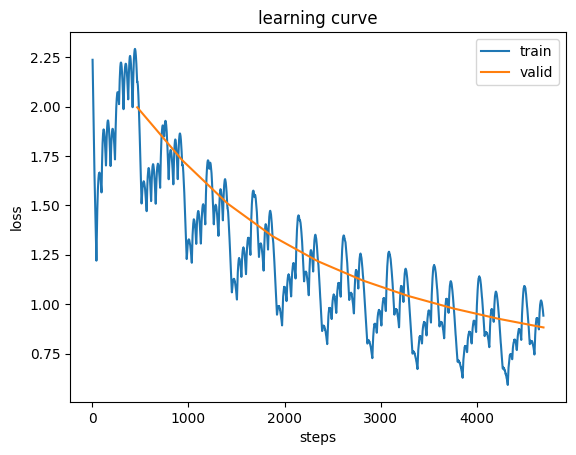

In [242]:
linear_learn.recorder.plot_loss()

# Using a simple neural network

In [225]:
simple_net = nn.Sequential(
    nn.Linear(28*28,128),
    nn.ReLU(),
    nn.Linear(128,10)
)

In [226]:
from fastai.callback.tracker import EarlyStoppingCallback
early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)

In [227]:
simple_net_learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=nn.CrossEntropyLoss(), metrics=batch_accuracy,
                           cbs=[early_stopping_cb])

In [228]:
simple_net_learn.fit(40, 0.0005)

epoch,train_loss,valid_loss,batch_accuracy,time
0,2.249492,2.217582,0.238083,00:03
1,2.138098,2.129518,0.335567,00:03
2,2.014911,2.025995,0.452417,00:04
3,1.872688,1.906403,0.499500,00:03
4,1.713489,1.776400,0.524967,00:03
5,1.552490,1.643815,0.542550,00:04
6,1.403660,1.516166,0.558417,00:03
7,1.273382,1.399774,0.576283,00:03
8,1.163309,1.297452,0.594133,00:04
9,1.071539,1.209320,0.612333,00:04


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

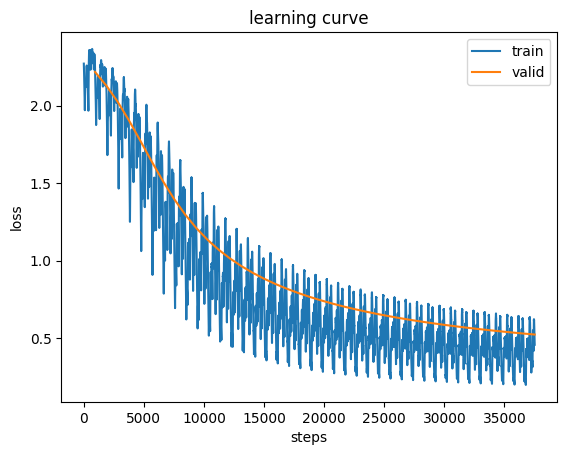

In [229]:
simple_net_learn.recorder.plot_loss()